<a href="https://colab.research.google.com/github/e101sg/IoT/blob/master/bounding_box_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Object detection: Bounding box regression with Keras, TensorFlow, and Deep Learning

### by [PyImageSearch.com](http://www.pyimagesearch.com)

In [32]:
!cd drive/MyDrive


In [33]:
!ls

drive  sample_data


### Import Packages

In [34]:
# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [35]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Define our `Config` class

In [49]:
class Config:
    # define the base path to the input dataset and then use it to derive
    # the path to the images directory and annotation CSV file
    BASE_PATH = "drive/MyDrive/ColabNotebooks/bounding-box-regression/dataset"
    IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
    ANNOTS_PATH = os.path.sep.join([BASE_PATH, "crack.csv"])

    # define the path to the base output directory
    BASE_OUTPUT = "drive/MyDrive/ColabNotebooks/bounding-box-regression/output"

    # define the path to the output serialized model, model training plot,
    # and testing image filenames
    MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
    PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
    TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

    # initialize our initial learning rate, number of epochs to train
    # for, and the batch size
    INIT_LR = 1e-4
    NUM_EPOCHS = 25
    BATCH_SIZE = 32

# instantiate the config class
config = Config()

### Implementing our bounding box regression training script with Keras and TensorFlow

In [45]:
print(config.ANNOTS_PATH)

drive/MyDrive/ColabNotebooks/bounding-box-regression/dataset/crack.csv


In [46]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(config.ANNOTS_PATH).read().strip().split("\n")

# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

[INFO] loading dataset...


In [42]:
!ls

drive  sample_data


In [47]:
# loop over the rows
for row in rows:
	# break the row into the filename and bounding box coordinates
	row = row.split(",")
	(filename, startX, startY, endX, endY) = row

	# derive the path to the input image, load the image (in OpenCV
	# format), and grab its dimensions
	imagePath = os.path.sep.join([config.IMAGES_PATH, filename])
	image = cv2.imread(imagePath)
	(h, w) = image.shape[:2]

	# scale the bounding box coordinates relative to the spatial
	# dimensions of the input image
	startX = float(startX) / w
	startY = float(startY) / h
	endX = float(endX) / w
	endY = float(endY) / h

	# load the image and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)

	# update our list of data, targets, and filenames
	data.append(image)
	targets.append((startX, startY, endX, endY))
	filenames.append(filename)

In [50]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(config.TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [51]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

58892288/58889256 [==============================] - 1s 0us/step


In [52]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=config.INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=config.BATCH_SIZE,
	epochs=config.NUM_EPOCHS,
	verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

[INFO] saving object detector model...


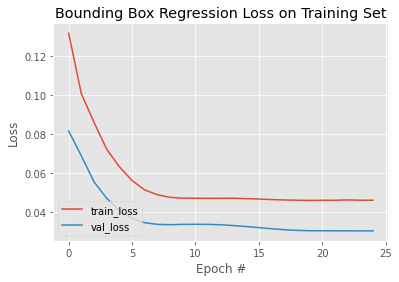

In [53]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(config.MODEL_PATH, save_format="h5")

# plot the model training history
N = config.NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

### Implementing our bounding box predictor with Keras and TensorFlow

In [62]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
# 	help="path to input image/text file of image filenames")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "input":"drive/MyDrive/ColabNotebooks/bounding-box-regression/output/test_images.txt"
}

In [63]:
# determine the input file type, but assume that we're working with
# single input image
filetype = mimetypes.guess_type(args["input"])[0]
imagePaths = [args["input"]]

# if the file type is a text file, then we need to process *multiple*
# images
if "text/plain" == filetype:
	# load the filenames in our testing file and initialize our list
	# of image paths
	filenames = open(args["input"]).read().strip().split("\n")
	imagePaths = []

	# loop over the filenames
	for f in filenames:
		# construct the full path to the image filename and then
		# update our image paths list
		p = os.path.sep.join([config.IMAGES_PATH, f])
		imagePaths.append(p)

In [71]:
print(imagePaths)

['drive/MyDrive/ColabNotebooks/bounding-box-regression/dataset/images/crack_32.jpg', 'drive/MyDrive/ColabNotebooks/bounding-box-regression/dataset/images/crack_2.jpg', 'drive/MyDrive/ColabNotebooks/bounding-box-regression/dataset/images/crack_022.jpg', 'drive/MyDrive/ColabNotebooks/bounding-box-regression/dataset/images/crack_11.jpg', 'drive/MyDrive/ColabNotebooks/bounding-box-regression/dataset/images/crack_45.jpg', 'drive/MyDrive/ColabNotebooks/bounding-box-regression/dataset/images/crack_40.jpg', 'drive/MyDrive/ColabNotebooks/bounding-box-regression/dataset/images/crack_63.jpg']


IndentationError: ignored

[INFO] loading object detector...


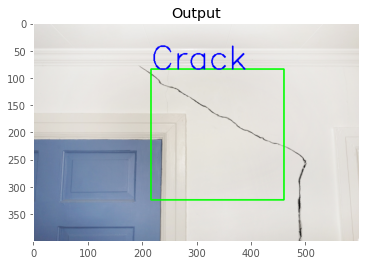

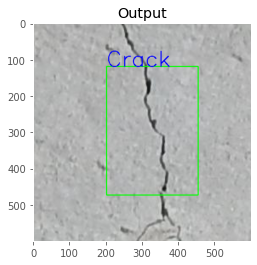

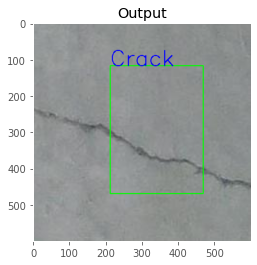

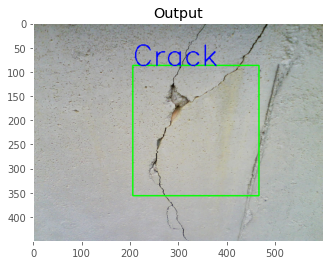

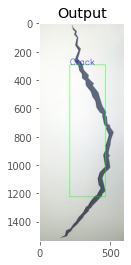

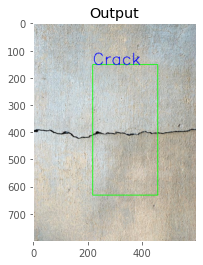

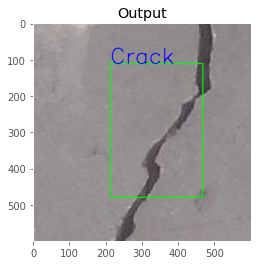

In [106]:
# load our trained bounding box regressor from disk
print("[INFO] loading object detector...")
model = load_model(config.MODEL_PATH)
import cv2

font = cv2.FONT_HERSHEY_SIMPLEX

# loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in imagePaths:
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # make bounding box predictions on the input image
    preds = model.predict(image)[0]
    (startX, startY, endX, endY) = preds

    # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]

    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # draw the predicted bounding box on the image
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
    org = (startX, startY)
    
    color = (255, 0, 0)
    cv2.putText(image, text="Crack",org=org, fontFace=font,color=color,fontScale = 2, thickness=2)

    # show the output image
    plt_imshow("Output", image)
 

In [1]:
!ls -la 



total 16
drwxr-xr-x 1 root root 4096 Apr 21 13:39 .
drwxr-xr-x 1 root root 4096 Apr 29 08:47 ..
drwxr-xr-x 4 root root 4096 Apr 21 13:38 .config
drwxr-xr-x 1 root root 4096 Apr 21 13:39 sample_data
